#### Setup

In [1]:
import numpy as np
import pandas as pd
import pickle
pd.set_option( 'display.max_columns', 100 )
pd.set_option( 'display.width', 200 )
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


#### Loans Dataset

In [2]:
l = pd.read_csv( 'loans.csv', parse_dates=[ 'application_date' ] )

In [3]:
l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27039 entries, 0 to 27038
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   application_id    27039 non-null  int64         
 1   application_date  27039 non-null  datetime64[ns]
 2   delay             27039 non-null  int64         
 3   bureau_score      27039 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 845.1 KB


In [4]:
l.head()

,application_id,application_date,delay,bureau_score
0,8808458,2020-02-10,-12,619
1,9399550,2020-05-03,0,507
2,8931336,2020-02-25,-1,433
3,8898960,2020-02-21,2,560
4,9321464,2020-04-15,-3,423


"application_id": unique identificator of a loan <br>
"application_date: date of an application for a loan <br>
"delay": number of days past due (0 - repaid at due date, positive values - overdue, negative values - early repayment) <br>
"bureau_score": credit score reported from the bureau at the moment of an application (it is not used in training the model and will serve as a benchmark)

#### Target Variable

In [5]:
l.delay.describe()

count    27039.000000
mean        20.920596
std         58.360589
min        -29.000000
25%         -5.000000
50%         -1.000000
75%          2.000000
max        226.000000
Name: delay, dtype: float64

In order to treat different vintages equally, "delay" needs to be limited by the range [0,91]:

In [6]:
l.loc[ l.delay < 0, 'delay' ] = 0
l.loc[ l.delay > 90, 'delay' ] = 91

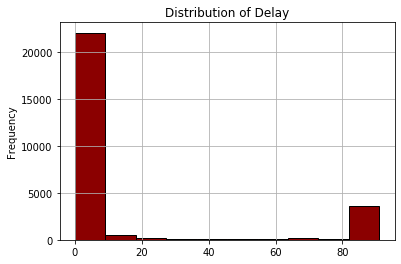

In [7]:
l.delay.plot( kind='hist', color='darkred', edgecolor='black', grid=True, title='Distribution of Delay' )

There is little interest in distinguishing high delays (>30) accurately, so the model will predict logarithm of "delay" :

In [8]:
l[ 'label' ] = np.log( l.delay + 1 )
l.label.describe()

count    27039.000000
mean         0.917328
std          1.638542
min          0.000000
25%          0.000000
50%          0.000000
75%          1.098612
max          4.521789
Name: label, dtype: float64

#### Train/Test Split

Let us create 4 folds for cross-validation. In this project they are randomly assigned.

In [9]:
np.random.seed( 0 )
l[ 'fold' ] = np.random.randint( 1, 5, size=l.shape[ 0 ] )
l.groupby( 'fold' ).agg({ 'application_id':'count', 'label':'mean' })

,application_id,label
fold,,
1,6739,0.916738
2,6796,0.911548
3,6726,0.936003
4,6778,0.905180


#### Credit History Dataset

In [10]:
c = pd.read_csv( 'bureau_data.csv', parse_dates=[ 'application_date', 'cred_date', 'cred_enddate', 
                                                 'cred_enddate_fact', 'cred_active_date', 'cred_update' ] )

This dataset contains information which is received from a credit history bureau at the moment of application for a new loan. In this project this information will be used to predict a customers's performance on the issued loan.

In [11]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546584 entries, 0 to 546583
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   application_id     546584 non-null  int64         
 1   application_date   546584 non-null  datetime64[ns]
 2   cred_type          546584 non-null  int64         
 3   cred_sum           546584 non-null  float64       
 4   cred_active        546584 non-null  int64         
 5   delay5             546584 non-null  int64         
 6   delay30            546584 non-null  int64         
 7   delay60            546584 non-null  int64         
 8   delay90            546584 non-null  int64         
 9   delay_more         546584 non-null  int64         
 10  cred_date          546584 non-null  datetime64[ns]
 11  cred_enddate       526350 non-null  datetime64[ns]
 12  cred_enddate_fact  406919 non-null  datetime64[ns]
 13  cred_sum_debt      546510 non-null  float64 

    Meaning of fields:
"application_id": unique identificator of a loan <br>
"application_date: date of an application for a loan <br>
"cred_type": type of a loan <br>
"cred_sum": amount of a loan <br>
"cred_active": status of a loan <br>
"delay5": number of delays up to 5 days <br>
"delay30": number of delays up to 30 days <br>
"delay60": number of delays up to 60 days <br>
"delay90": number of delays up to 90 days <br>
"delay_more": number of delays more than 90 days <br> 
"cred_date": date of a loan <br>
"cred_enddate": due date of a loan <br>
"cred_enddate_fact": date when a loan was completed <br>
"cred_sum_debt": current debt on a loan <br>
"cred_max_overdue": maximum delay on a loan <br>
"cred_sum_overdue": current outstanding amount <br>
"cred_day_overdue": duration of current delay <br>
"cred_prolong": whether a loan was extended <br>
"cred_active_date": date of the last status change <br>
"cred_update": date of the last update on a loan <br>
"cred_partner_type": type of company issued a loan <br>
"cred_collateral": whether a loan is secured with a collateral <br>
"payment_pattern": payment behaviour on a loan by months

So, each application from the loans dataset ("l") corresponds to multiple records in the credit history dataset ("c"). An example of records corresponding to a particular application:

In [12]:
c.loc[ c.application_id == 9321464 ]

,application_id,application_date,cred_type,cred_sum,cred_active,delay5,delay30,delay60,delay90,delay_more,cred_date,cred_enddate,cred_enddate_fact,cred_sum_debt,cred_max_overdue,cred_sum_overdue,cred_day_overdue,cred_prolong,cred_active_date,cred_update,cred_partner_type,cred_collateral,payment_pattern
49,9321464,2020-04-15,5,5889.57,1,1,1,0,0,0,2019-11-18,2020-08-23,NaT,2972.17,537.67,0.0,0,0,2020-03-25,2020-03-25,1,0,-02210
50,9321464,2020-04-15,5,10170.97,0,0,2,0,0,0,2018-03-20,2018-09-25,2018-10-02,0.00,1824.22,0.0,0,0,2018-10-02,2018-10-02,1,0,CCCCCCCCCCCCCCCCCC2120000-
51,9321464,2020-04-15,5,11599.00,0,1,1,0,0,0,2019-10-09,2020-04-09,2020-04-09,0.00,1957.48,0.0,0,0,2020-04-09,2020-04-09,1,0,C010020
52,9321464,2020-04-15,5,8119.00,0,0,0,0,0,0,2018-07-30,2019-02-01,2019-02-01,0.00,0.00,0.0,0,0,2019-02-01,2019-02-01,1,0,CCCCCCCCCCCCCCC000000-
53,9321464,2020-04-15,5,9587.90,0,1,0,0,0,0,2019-01-17,2019-11-18,2019-09-17,0.00,972.75,0.0,0,0,2019-09-17,2019-09-17,1,0,CCCCCCCC10000000
54,9321464,2020-04-15,4,5000.00,0,1,0,0,0,0,2018-12-27,2019-09-15,2019-09-15,0.00,600.00,0.0,0,0,2019-09-15,2019-09-15,1,0,CCCCCCCC000010000
55,9321464,2020-04-15,5,15510.28,1,0,0,0,0,0,2019-06-06,2020-06-08,NaT,2713.52,0.00,0.0,0,0,2019-06-06,2020-04-06,1,0,00000000000


So this applicant has 7 records (loans) in his credit history.

The dataset needs to be sorted by "application_id" and in reverse chronological order (by the attribute "cred_update"):

In [13]:
c.sort_values( by=[ 'application_id', 'cred_update', 'cred_active_date', 'cred_date' ], 
              ascending=[ True, False, False, False ], inplace=True )

In [14]:
c.tail()

,application_id,application_date,cred_type,cred_sum,cred_active,delay5,delay30,delay60,delay90,delay_more,cred_date,cred_enddate,cred_enddate_fact,cred_sum_debt,cred_max_overdue,cred_sum_overdue,cred_day_overdue,cred_prolong,cred_active_date,cred_update,cred_partner_type,cred_collateral,payment_pattern
69263,9697473,2020-07-24,19,1000.0,0,0,0,0,0,0,2019-09-01,2019-09-13,2019-09-10,0.00,0.0,0.0,0,0,2019-09-10,2019-09-17,3,0,CCCCCCCCCCC
69266,9697473,2020-07-24,19,1100.0,0,0,0,0,0,0,2019-08-17,2019-08-28,2019-08-27,0.00,0.0,0.0,0,0,2019-08-27,2019-09-02,3,0,CCCCCCCCCCC-
377065,9698504,2020-07-24,5,4655.0,1,0,0,0,0,0,2020-06-12,2020-10-12,NaT,3627.26,0.0,0.0,0,0,2020-07-12,2020-07-12,3,0,00
377066,9698504,2020-07-24,5,4219.0,0,0,0,0,0,0,2019-09-05,2020-07-11,2020-07-11,0.00,0.0,0.0,0,1,2020-07-11,2020-07-12,3,0,C0000000000
377064,9698504,2020-07-24,4,15000.0,0,0,0,0,0,0,2019-04-17,2019-11-10,2019-11-10,0.00,0.0,0.0,0,0,2019-11-10,2019-11-10,1,0,CCCCCCCCC0000000


In order to serve as input for a convolutional neural network, all the relevant features should be scaled. In this case the features will be scaled to the range [0,1]. This allows to conveniently combine binary, time and numeric features.

#### Split-Independent Transformations

In [15]:
c.cred_type.value_counts()

19    365945
5     101766
4      58592
18     10027
14      2351
99      2162
1       2011
24      1956
3       1107
20       425
6        102
0         90
7         30
9         11
8          5
16         3
13         1
Name: cred_type, dtype: int64

One-hot encoding of "cred_type":

In [16]:
c[ 'pay_day_loan' ] = np.where( c.cred_type.isin([ 19, 20 ]), 1, 0 )
c[ 'cash_loan' ] = np.where( c.cred_type == 18, 1, 0 )
c[ 'consumer_loan' ] = np.where( c.cred_type == 5, 1, 0 )
c[ 'revolver_loan' ] = np.where( c.cred_type.isin([ 4, 14, 24 ]), 1, 0 )
c[ 'secured_loan' ] = np.where( c.cred_type.isin([ 1, 3, 15, 16 ]), 1, 0 )
c[ 'other_loan' ] = np.where( c.cred_type.isin([ 19, 20, 18, 5, 4, 14, 24, 1, 3, 15, 16 ]), 0, 1 )

In [17]:
c.cred_active.value_counts()

0    398023
1    139665
2      5844
5      1333
8      1064
3       514
4       128
9        13
Name: cred_active, dtype: int64

Rare active statuses are encoded as "1", too:

In [18]:
c.loc[ c.cred_active.isin([ 2, 3, 4, 5, 8, 9 ]), 'cred_active' ] = 1

Let us replace "cred_enddate" with term of a loan (in days):

In [19]:
c[ 'term' ] = ( c.cred_enddate - c.cred_date ).dt.days
c.loc[ c.term <= 0, 'term' ] = np.nan

Date features are transformed using exponential function (with such parameter that a date of one year before the application date is equal to 0.5):

In [20]:
def scale_date( x ) :
    c[ x ] = ( c[ 'application_date' ] - c[ x ] ).dt.days
    c[ x ] = np.exp( -0.0019 * c[ x ] )

In [21]:
for name in [ 'cred_date', 'cred_active_date', 'cred_update' ] :
    scale_date( name )

"cred_enddate_fact" mostly indicates whether a loan was completed or not, so it is transformed into a binary feature:

In [22]:
c[ 'cred_enddate_fact' ] = np.where( c.cred_enddate_fact.isnull(), 1, 0 )

In [23]:
c.cred_partner_type.value_counts()

3     370455
1     173549
5       2045
99       428
6        105
13         2
Name: cred_partner_type, dtype: int64

"cred_partner_type" is usually micro-financing company ("3") or bank ("1"), so it is transformed to a binary feature:

In [24]:
c[ 'cred_partner_type' ] = np.where( c.cred_partner_type == 3, 0, 1 )

#### Split-Dependant Transormations

Numeric features are transformed with sigmoid function, also using their mean and standard deviation (which act as parameters of the model, and, therefore, should be estimated on the train sample only). Besides, missing values are replaced with the sample means.

In [25]:
c = c.merge( l[[ 'application_id', 'fold' ]], on='application_id', how='inner' )

In [26]:
def scale_numeric( x ) :
    for f in [ 1, 2, 3, 4 ] :
        m = c.loc[ c.fold != f, x ].mean()
        sd = c.loc[ c.fold != f, x ].std()
        scaled = ( c.loc[ c.fold == f, x ] - m ) / sd
        c.loc[ c.fold == f, x ] = 1 / ( 1 + np.exp( -scaled ) )
        c.loc[ c[ x ].isnull(), x ] = c.loc[ c.fold != f, x ].mean()

In [27]:
for name in [ 'cred_sum', 'delay5', 'delay30', 'delay60', 'delay90', 'delay_more', 'cred_sum_debt',
              'cred_max_overdue', 'cred_sum_overdue', 'cred_day_overdue', 'term' ] :
    scale_numeric( name )

#### Payment Pattern

Payment pattern reflects payment discipline of a customer on a particular loan, so it needs special attention.

In [28]:
c.payment_pattern.head( 10 )

0         CC
1         C-
2         C-
3         0-
4         -0
5    -00----
6         CC
7         -0
8        CC0
9         0-
Name: payment_pattern, dtype: object

It has a variable length, but, according to the bureau's recommendations, the first (recent) 25 characters are taken:

In [29]:
c[ 'pattern' ] = c.payment_pattern.str.slice( 0, 25 )

The right edge is padded to the standard length with "-":

In [30]:
c[ 'pattern_padded' ] = c.pattern.str.pad( width=25, side='right', fillchar='-' )
c[[ 'payment_pattern', 'pattern' ]].head( 10 )

,payment_pattern,pattern
0,CC,CC
1,C-,C-
2,C-,C-
3,0-,0-
4,-0,-0
5,-00----,-00----
6,CC,CC
7,-0,-0
8,CC0,CC0
9,0-,0-


Then each character becomes a separate feature:

In [31]:
for i in range( 25 ) :
    c[ 'p'+str( i ) ] = c.pattern_padded.str.get( i )

In [32]:
c.iloc[ :10, 31: ]

,pattern,pattern_padded,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24
0,CC,CC-----------------------,C,C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,C-,C------------------------,C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,C-,C------------------------,C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,0-,0------------------------,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,-0,-0-----------------------,-,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
5,-00----,-00----------------------,-,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
6,CC,CC-----------------------,C,C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7,-0,-0-----------------------,-,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
8,CC0,CC0----------------------,C,C,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
9,0-,0------------------------,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


The caracters are replaced with numeric values of the range [0,1] defined based on the documentation:

In [34]:
for col in c.iloc[ :, 33: ].columns :
    c.loc[ c[ col ].isin([ '-', 'I', 'N', '0', 'C', 'R' ]), col ] = 0
    c.loc[ c[ col ] == '1', col ] = 0.1
    c.loc[ c[ col ] == '2', col ] = 0.2
    c.loc[ c[ col ] == '3', col ] = 0.3
    c.loc[ c[ col ] == '4', col ] = 0.4
    c.loc[ c[ col ] == '5', col ] = 0.5
    c.loc[ c[ col ] == '6', col ] = 0.6
    c.loc[ c[ col ] == '7', col ] = 0.7
    c.loc[ c[ col ] == '8', col ] = 0.8
    c.loc[ c[ col ] == '9', col ] = 0.9
    c.loc[ c[ col ].isin([ 'B', 'S', 'W', 'U', 'T' ]), col ] = 1
    c[ col ] = pd.to_numeric( c[ col ] )

In [35]:
c.iloc[ :, 31: ].sample( 10 )

,pattern,pattern_padded,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24
287837,-0,-0-----------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34248,CCCCC,CCCCC--------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53047,0000000000000000000000000,0000000000000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196123,CCCCCCCCCC20,CCCCCCCCCC20-------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217799,CCCCCCCCCC0,CCCCCCCCCC0--------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500786,CCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316119,-000,-000---------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351755,CC,CC-----------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67576,-00000,-00000-------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8388,CCCC------------------,CCCC---------------------,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Extra columns are removed:

In [36]:
c.drop( [ 'application_date', 'cred_type', 'cred_enddate', 'payment_pattern', 'fold', 'pattern_padded' ], 
       axis=1, inplace=True )

Number of records (loans) in credit history vary for each application (customer). But in order to serve as input for a convolutional neural network, they need to be equalised. Let us take so many most recent records that 80% of applications are not trimmed.
At first it is necessary to examine the distribution of the number of records.

In [37]:
c.groupby( 'application_id' )[ 'cred_sum' ].count().describe()

count    27039.000000
mean        20.208255
std         33.520753
min          1.000000
25%          6.000000
50%         12.000000
75%         24.000000
max       2142.000000
Name: cred_sum, dtype: float64

In [38]:
c.groupby( 'application_id' )[ 'cred_sum' ].count().quantile( 0.8 )

28.0

So number of credit records will be limited by 27. Let us define a function which takes only the 27 most recent records. If the number is lower, dummy rows filled with "0" are appended to the bottom.

In [39]:
features_data = np.empty(( 0, 27, 50 ))

A function to transform the input into a 3-dimensional array:

In [40]:
def features_to_3d ( x ) :
    global feautures_data
    application_records = c.loc[ c.application_id == x ].values
    matrix = application_records[ :27, 1: ]
    nrec = matrix.shape[ 0 ]
    if nrec < 27 :
        matrix = np.vstack([ matrix, np.zeros(( 27-nrec, 50 )) ])
    matrix = matrix.reshape(( 1, 27, 50 ))
    feautures_data = np.vstack([ feautures_data, matrix ])

In [47]:
l.application_id.apply( features_to_3d )

In [48]:
features_data.shape

(27039, 27, 50)

Now each label corresponds to a 2-dimensional matrix (27x50) of features. This is desired input for a convolutional neural network.

In [49]:
features_data = np.float32( features_data.reshape( 27039, 27, 50, 1 ) )

#### Cross-Validation of the Convolutional Neural Network

Cross-validation on 4 folds (75%/25%) will be carried out. On each fold Mean Squared Error of the CNN model will be measured and compared to naive approach: simple sample mean.

In [50]:
t = pd.DataFrame( index=[ 1, 2, 3, 4 ] )
t[ 'mse_cnn' ] = 0.0
t[ 'epochs' ] = 0
t[ 'mse_naive' ] = 0.0

In [51]:
stop = EarlyStopping( patience=10, restore_best_weights=True )

Loop for configuring the CNN and cross-validation:

In [ ]:
for i in t.index :
    ytrain = np.float32( l.loc[ l.fold != i, 'label' ] )
    ytest = np.float32( l.loc[ l.fold == i, 'label' ] )
    xtrain = features_data[ l.fold != i, :, :, : ] 
    xtest = features_data[ l.fold == i, :, :, : ]
    batch = xtrain.shape[ 0 ]
    naive = np.mean( ytrain )
    cnn_model = Sequential()
    cnn_model.add( Conv2D( filters=5, kernel_size=( 27, 5 ), padding='same', 
        kernel_initializer='zeros', bias_initializer='zeros', input_shape=( 27, 50, 1 ) ) )
    cnn_model.add( AveragePooling2D( pool_size=( 27, 5 ) ) )
    cnn_model.add( Flatten() )
    cnn_model.add( Dense( 5, kernel_initializer='zeros', bias_initializer='zeros', activation='tanh' ) )
    cnn_model.add( Dense( 1, kernel_initializer='zeros', bias_initializer='zeros' ) )
    cnn_model.compile( optimizer='adam', loss='mean_squared_error' )
    fitting = cnn_model.fit( xtrain, ytrain, batch_size=batch, validation_data=( xtest, ytest ), 
        shuffle=False, epochs=10000, callbacks=[ stop ] )
    fithistory = pd.DataFrame( fitting.history )
    t.loc[ i, 'epochs' ] = fithistory.shape[ 0 ] - 10
    t.loc[ i, 'mse_cnn' ] = fithistory.val_loss.min()
    l.loc[ l.fold == i, 'pred_cnn' ] = cnn_model.predict( xtest )
    l.loc[ l.fold == i, 'pred_naive' ] = naive
    t.loc[ i, 'mse_naive' ] = np.mean( ( ytest - naive )**2 )
    del [ xtrain, xtest, ytrain, ytest, naive, cnn_model, fitting, fithistory ]

In [53]:
t

,mse_cnn,epochs,mse_naive
1,2.691235,1990,2.691137
2,2.662989,1911,2.663002
3,2.721143,2313,2.721015
4,2.664277,1808,2.664509


In [54]:
print( t.mse_cnn.mean() )
print( t.mse_naive.mean() )

2.6849108934402466
2.6849159002304077


#### Conclusion

It can be seen that the performance metric (Mean Squared Error) of the CNN is obviously not better than the one of the naive approach (sample mean). It does not make sense to further compare to a competitive benchmark. However, this is a very compact neural network, and other parameters or a configuration with more layers and filters may show different results.